# Tutorial

## Introduction

In [1]:
import numpy as np
import spox

### Types

Before creating an ONNX model we will have to specify argument argument types, so that Spox can conduct inference and create a correct model. 

Spox exposes types like `Tensor`, `Sequence`, `Optional`. `Tensor` is the most common.

In this example, we specify:


- Vector of 32-bit floats
- K by 2 matrix (K pairs) of 64-bit integers.
- Array of strings of unknown shape.

In [2]:
VectorF32 = spox.Tensor(np.float32, (None,))
KPairsI64 = spox.Tensor(np.int64, ('K', 2))
Strings = spox.Tensor(np.str_)

In shape dimensions:

- Integers are used for constant, known dimensions.
- Strings and `None` are used for dimensions unknown at runtime.

- With strings we can add basic annotations for dimensions that are the same accross many shapes (and tensors).

Sometimes (especially if shape inference fails), a shape is entirely unknown, including its rank. This may be an error when specifying the entire model, but is nevertheless possible.

Spox provides some neater C-style string representations for this.

In [3]:
print(f"{VectorF32 = !s}")
print(f"{KPairsI64 = !s}")
print(f"{Strings = !s}")

VectorF32 = float32[?]
KPairsI64 = int64[K][2]
Strings = str[...]


### Vars

To start performing any interesting computation, you have to get your hands on an instance of `Var`.

You could create a constant-valued Var with a respective operator, but it's more useful to create an **argument** (a placeholder for a value), which will later become a **model input**.

The function used for creating an argument is `spox.argument(typ: Type) -> Var`.

In [4]:
u = spox.argument(VectorF32)
v = spox.argument(VectorF32)

String representations for Vars tell you a bit on what information they store:

In [5]:
print(f"{u = !s}")

u = <Var from spox.internal@0::Argument->arg of float32[?]>


As we expected, `u` is an argument `Var`, which is a vector of 32-bit floats.

## Construction

### Importing opsets

In ONNX, operators live in domains (kind of like packages), which are versioned with natural numbers.

- For example, the current (default) domain is `ai.onnx` at version 17.
- Another standard domain that we often use, as it is useful for traditional ML, is `ai.onnx.ml` - currently at version 3.

A domain and a version is often called an *opset* (operator set). Spox exposes them as Python modules, where all the definitions for included operators reside:

In [6]:
import spox.opset.ai.onnx.v17 as op    # op - ai.onnx@17
import spox.opset.ai.onnx.ml.v3 as ml  # ml - ai.onnx.ml@3

These operators are exposed as *operator constructors*, which are just Python functions that you give Vars and other parameters to. 
They return more Vars.

For example, the `ai.onnx@17::Add` operator has the constructor `add`:

---

In [7]:
help(op.add)

Help on function add in module spox.opset.ai.onnx.v17:

add(A: spox._var.Var, B: spox._var.Var) -> spox._var.Var
    Performs element-wise binary addition (with Numpy-style broadcasting
    support).
    
    This operator supports **multidirectional (i.e., Numpy-style)
    broadcasting**; for more details please check `the
    doc <https://github.com/onnx/onnx/blob/main/docs/Broadcasting.md>`__.
    
    (Opset 14 change): Extend supported types to include uint8, int8,
    uint16, and int16.
    
    Parameters
    A
        Type T.
        First operand.
    B
        Type T.
        Second operand.
    
    Returns
    C : Var
        Type T.
        Result, has same element type as two inputs
    
    Notes
    =====
    Signature: ``ai.onnx@14::Add``.
    
    Type constraints:
     - T: `tensor(bfloat16)`, `tensor(double)`, `tensor(float)`, `tensor(float16)`, `tensor(int16)`, `tensor(int32)`, `tensor(int64)`, `tensor(int8)`, `tensor(uint16)`, `tensor(uint32)`, `tensor(uint64)`, `

**This doc is auto-generated with internal schema docs and data within the `onnx` reference implementation.**

---

### Applying operators

We will now define the example network from the slides. Start with the necessary arguments:

In [8]:
a = spox.argument(spox.Tensor(np.int64, ("N", "M")))
b = spox.argument(spox.Tensor(np.int64, ("N", 1)))
x = spox.argument(spox.Tensor(np.int64, ("M", 1)))

Now, apply all of the necessary operators. Notice that intermediate values are just Vars that we pass on, and Spox is typing them!

In [9]:
ax = op.matmul(a, x)
ax

<Var from ai.onnx@13::MatMul->Y of int64[N][1]>

In [10]:
summed = op.reduce_sum(op.add(b, ax))
summed

<Var from ai.onnx@13::ReduceSum->reduced of int64[1][1]>

As we're reshaping this into a scalar at the end (scalars have an empty shape), we need to construct a Var representing that constant.


In [11]:
empty_shape = op.constant(value=np.array([], dtype=np.int64))
empty_shape

<Var from ai.onnx@13::Constant->output of int64[0] = []>

In [12]:
result = op.reshape(summed, empty_shape)
result

<Var from ai.onnx@14::Reshape->reshaped of int64>

## Exceptions

This is a short demonstration that Spox will stop you from making ONNX type errors as soon as possible.

In [13]:
try:
    # Add a matrix of integers to a string
    op.add(a, op.constant(value_string="abc"))
except Exception as e:
    print(f"{type(e).__name__}: {e}")

InferenceError: [ShapeInferenceError] (op_type:Add, node name: _this_): B typestr: T, has unsupported type: tensor(string) -- for Add: inputs [A: int64[N][M], B: str = <Propagated abc: str>]


The slightly unfortunate formatting of the error is due to the fact it is *hardcoded in ONNX's C++ implementation* of type inference. 

What we *can* read from it, though:

- The traceback (not displayed here) does lead to the offending line - the failing operator is an Add.
- We inputted types `int64[N][M]` and a `str` (as a side note, here Spox knows it's of constant value `"abc"`).
- The input called `B` of type variable `T` - these are explained in the docstring - was a tensor of strings, which is unsupported.

In [14]:
try:
    # Add mismatched-length vectors
    op.add(op.const([1, 2]), op.const([1, 2, 3]))
except Exception as e:
    print(f"{type(e).__name__}: {e}")

InferenceError: [ShapeInferenceError] Shape inference error(s): (op_type:Add, node name: _this_): [ShapeInferenceError] Incompatible dimensions
 -- for Add: inputs [A: int64[2] = <Propagated [1 2]: int64[2]>, B: int64[3] = <Propagated [1 2 3]: int64[3]>]


## Building

Once you've constructed the computation you want, the last step is to _build_ an `onnx.ModelProto`. First, locate all the results you would like to include and arguments you used to compute them:


In [15]:
a, b, x

(<Var from spox.internal@0::Argument->arg of int64[N][M]>,
 <Var from spox.internal@0::Argument->arg of int64[N][1]>,
 <Var from spox.internal@0::Argument->arg of int64[M][1]>)

In [16]:
result

<Var from ai.onnx@14::Reshape->reshaped of int64>

Once you've reached this step there is nothing more to do than invoke the compilation process and get an ONNX model.

The `build(inputs: dict[str, Var], outputs: dict[str, Var]) -> onnx.ModelProto` takes the 'signature' of the built model. The dictionaries specify the name and ordering of the model inputs/outputs.

In [17]:
onnx_model = spox.build({'a': a, 'b': b, 'x': x}, {'y': result})

## Working with ONNX

### Exploring

We start with importing the ONNX reference implementation and ONNX Runtime (ORT).

In [18]:
import onnx
import onnxruntime

### Saving and visualisation

Our model is serializable to a bunch of bytes (since it's a protobuf object):

In [19]:
type(onnx_model)

onnx.onnx_ml_pb2.ModelProto

In [20]:
onnx_model.SerializeToString()

b'\x08\x08\x12\x04spox2\x00:\xef\x03\n&\n\x01a\n\x01x\x12\nMatMul_0_Y\x1a\x08MatMul_0"\x06MatMul:\x00\n&\n\x01b\n\nMatMul_0_Y\x12\x07Add_0_C\x1a\x05Add_0"\x03Add:\x00\nf\n\x07Add_0_C\x12\x13ReduceSum_0_reduced\x1a\x0bReduceSum_0"\tReduceSum*\x0f\n\x08keepdims\x18\x01\xa0\x01\x02*\x1b\n\x14noop_with_empty_axes\x18\x00\xa0\x01\x02:\x00\n?\x12\x11Constant_0_output\x1a\nConstant_0"\x08Constant*\x12\n\x05value*\x06\x08\x00\x10\x07B\x00\xa0\x01\x04:\x00\nd\n\x13ReduceSum_0_reduced\n\x11Constant_0_output\x12\x12Reshape_0_reshaped\x1a\tReshape_0"\x07Reshape*\x10\n\tallowzero\x18\x00\xa0\x01\x02:\x00\n2\n\x12Reshape_0_reshaped\x12\x01y\x1a\x0fIntroduce_0_id0"\x08Identity\x12\nspox_graphZ\x15\n\x01a\x12\x10\n\x0e\x08\x07\x12\n\n\x03\x12\x01N\n\x03\x12\x01MZ\x14\n\x01b\x12\x0f\n\r\x08\x07\x12\t\n\x03\x12\x01N\n\x02\x08\x01Z\x14\n\x01x\x12\x0f\n\r\x08\x07\x12\t\n\x03\x12\x01M\n\x02\x08\x01b\x0b\n\x01y\x12\x06\n\x04\x08\x07\x12\x00B\x04\n\x00\x10\x0e'

It also has a pretty-print:

In [21]:
onnx_model

ir_version: 8
producer_name: "spox"
doc_string: ""
graph {
  node {
    input: "a"
    input: "x"
    output: "MatMul_0_Y"
    name: "MatMul_0"
    op_type: "MatMul"
    domain: ""
  }
  node {
    input: "b"
    input: "MatMul_0_Y"
    output: "Add_0_C"
    name: "Add_0"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "Add_0_C"
    output: "ReduceSum_0_reduced"
    name: "ReduceSum_0"
    op_type: "ReduceSum"
    attribute {
      name: "keepdims"
      i: 1
      type: INT
    }
    attribute {
      name: "noop_with_empty_axes"
      i: 0
      type: INT
    }
    domain: ""
  }
  node {
    output: "Constant_0_output"
    name: "Constant_0"
    op_type: "Constant"
    attribute {
      name: "value"
      t {
        dims: 0
        data_type: 7
        name: ""
      }
      type: TENSOR
    }
    domain: ""
  }
  node {
    input: "ReduceSum_0_reduced"
    input: "Constant_0_output"
    output: "Reshape_0_reshaped"
    name: "Reshape_0"
    op_type: "Reshape"
    attrib

We could save it to an ONNX file and then visualise it at https://netron.app by a call like `onnx.save(onnx_model, "example.onnx")`.

<img src="example-model-netron.png" width=200>

*Nota bene*: the extra Identity at the end is a technical requirement of ONNX in some cases. It can be easily got rid of by using a model optimizer after compilation.

### Running

We use ONNX Runtime's Python bindings to load and run the model.

Notice that Spox is completely independent of this, as we are loading the model from the filesystem.

In [22]:
onnxruntime.InferenceSession(onnx_model.SerializeToString()).run(None, {
    'a': np.array([[1, 1], [1, 0]]),  # Fibonacci's sequence matrix
    'x': np.array([[8], [5]]),        # F_6, F_5
    'b': np.array([[1], [-1]])        # 1 - 1 = 0
})  # -> F_8

[array(21, dtype=int64)]

## Summary

A slightly longer program computing Gramian Angular Fields (come up in image processing with NNs, but mostly look nice).

In [23]:
# Arguments
arg_u = spox.argument(spox.Tensor(np.float32, ("N", "K")))
arg_v = spox.argument(spox.Tensor(np.float32, ("M", "K")))

# Manipulate shapes a bit to exploit broadcasting for an outer product computation
u = op.unsqueeze(arg_u, op.const([1]))
v = op.unsqueeze(arg_v, op.const([0]))

print(f"{u.type = !s}, {v.type = !s}")

# Dot product, along the last axis
def dot(x: spox.Var, y: spox.Var) -> spox.Var:
    # Multiply point wise 
    return op.reduce_sum(op.mul(x, y), axes=op.const([-1]))

# Main computation - u*v - sqrt(1 - u^2)*sqrt(1 - v^2)
gram = op.sub(
    dot(u, v),
    dot(
        op.sqrt(op.sub(op.const(1.), op.mul(u, u))),
        op.sqrt(op.sub(op.const(1.), op.mul(v, v))),
    )
)
gram = op.squeeze(gram, axes=op.const([-1]))

print(f"{gram.type = !s}")

# Create a graph and run on example
gaf_model = spox.build({'u': arg_u, 'v': arg_v}, {'gram': gram})
gaf_session = onnxruntime.InferenceSession(gaf_model.SerializeToString())

def gaf(us, vs):
    return gaf_session.run(None, {
        'u': np.array(us, dtype=np.float32), 'v': np.array(vs, dtype=np.float32)
    })[0]

u.type = float32[N][1][K], v.type = float32[1][M][K]
gram.type = float32[N][M]


In [24]:
import matplotlib.pyplot as plt

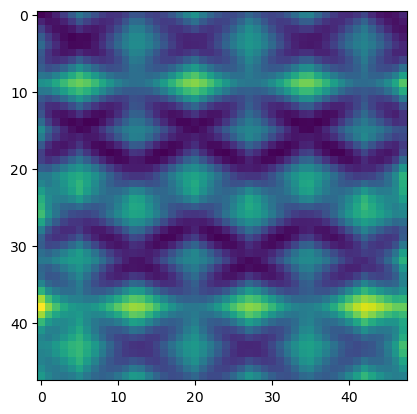

In [25]:
example_gaf = gaf(
    [(np.sin(1.3*x), x/10, np.cos(x)) for x in np.linspace(-10, 10, 48)],
    [(np.sin(x), (x/10)**2, 0.7) for x in np.linspace(-10, 10, 48)]
)
plt.imshow(example_gaf)